# 1. Load Necessary Packages

In [1]:
import dynetan as dna
import networkx.algorithms.community.quality as nxquality
import os
import MDAnalysis as mda
import numpy as np
from collections import defaultdict
import pandas as pd
from dynetan.toolkit import getNodeFromSel, getSelFromNode
from dynetan.viz import prepTclViz
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import matplotlib as mpl
import networkx as nx
from glob import glob
import shutil

mpl.rcParams['font.size'] = 9
mpl.rcParams['lines.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['patch.linewidth'] = 2.0
mpl.rcParams['legend.frameon'] = False
mpl.font_manager.findSystemFonts(fontpaths="/home/marco/.local/share/fonts", fontext="ttf")
mpl.rcParams['font.family'] = 'Oswald'

palette = ['royalblue', 'darkorange','forestgreen']

/home/marco/anaconda3/envs/dynet/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


# 2. Dynet analysis
Define path for filed and create the object

In [54]:
# define path for data files
dataDir = "../04-dynet/7XP6"
fileNameRoot = "dnaData"
fullPathRoot = os.path.join(dataDir, fileNameRoot)
dcdVizFile = fullPathRoot + "_reducedTraj.dcd"
pdbVizFile = fullPathRoot + "_reducedTraj.pdb"
workUviz = mda.Universe(pdbVizFile, dcdVizFile)
workDir = os.path.abspath(dataDir)

# Load the Dynamic Network Analyzer object
dnad = dna.datastorage.DNAdata()
dnad.loadFromFile(fullPathRoot)

# create correspondence between atom index and node from reduced trajectory
dnad.nodesAtmSel = workUviz.atoms[ dnad.nodesIxArray ]

atomToNode int64 (2466,) 2466
contactMat int64 (300, 300) 90000
corrMatAll float64 (1, 300, 300) 90000
distsAll float64 (1, 300, 300) 90000
maxDirectDist float64 () 1
maxDist float64 () 1
nodesIxArray int64 (300,) 300
numNodes int32 () 1


/home/marco/anaconda3/envs/dynet/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


## Analysis of the network

In [55]:
# Creates a list of windows and order them according to graph modularity.
# The modularity tells us how well the nodes are grouped into distinct communities.
windModul = []
for window in range(dnad.numWinds):
    modul = nxquality.modularity(dnad.nxGraphs[window], 
                         [ set(nodesList) for nodesList in dnad.nodesComm[window]["commNodes"].values()])
    windModul.append((window, modul))
    
windModul.sort(key=lambda x:x[1], reverse=True)

# Keep the window with the highest modularity as a reference for community matching
refWindow = windModul[0][0]

for wind, mod in windModul[:5]:
    print( "Window {} has modularity {:1.4f}.".format(wind, mod) )

Window 0 has modularity 0.7553.


In [56]:
# This part of code is used to match communities between windows.
# The matching is done by comparing the intersection of nodes between communities.
# The community with the largest intersection is selected as the matching community.
# The cutoff is used to ignore communities with less than 10% of the nodes.

cutoff = max(10, np.ceil(0.01*dnad.numNodes))
def matchComm(mCommID, mWindow, refWindow, dnad, cutoff=1):
    """
    Returns the community ID for the reference window that has the largest
    intersection with the matching community at the matching window.
    Communities at the reference window with less than *cutoff* percent of nodes
    are ignored.
    """
    
    trgtComm = -1
    intersectSize = 0
    for commID in dnad.nodesComm[refWindow]["commOrderSize"]:
        # Skip community if it has less than *cutoff* percent of the nodes.
        commSize = len(dnad.nodesComm[refWindow]["commNodes"][commID])
        if commSize < cutoff:
            continue
        
        tmpSize = len( set(dnad.nodesComm[refWindow]["commNodes"][commID]).intersection( 
            set(dnad.nodesComm[mWindow]["commNodes"][mCommID]) ) )
        
        # Selects the largets intersection
        if intersectSize < tmpSize:
            intersectSize = tmpSize
            trgtComm = commID
    
    return trgtComm, intersectSize

print("Using reference window {0} with highest modularity {1:<1.4}".format(*windModul[0]))

communities = defaultdict(list)
for window in range(dnad.numWinds):
    for commID in dnad.nodesComm[window]["commOrderSize"]:
        
        # Skip community if it has less than one percent of the nodes.
        commSize = len(dnad.nodesComm[window]["commNodes"][commID])
        if commSize < cutoff:
            continue
        
        matchID, interSize = matchComm(commID, window, refWindow, dnad, cutoff)
        
        communities[matchID].append( (commID, interSize, window) )
        
communities = {key:val for (key,val) in communities.items() }

# Creates a list of communities ID from the dictionary keys
# Orders the keys according to mean intersection size over all windows.
tmpList = []
for key,val in communities.items():
    tmpList.append((key, np.mean([pair[1] for pair in val]), len(val)))
tmpList.sort(key=lambda x:x[1], reverse=True)

# Creates a pandas data frame for plotting and analysis
commList = []
genCommID = 0
for key in [x[0] for x in tmpList]:
    val = communities[key]
    for valList in val:
        commList.append( [genCommID, *valList ] )
    genCommID += 1

commDF = pd.DataFrame(data=commList, columns=["genCommID","commID","interSize","Window"])

# Changes "genCommID" for communities that are matched to the same community in the reference window.
c = commDF.groupby(["genCommID","Window"]).cumcount()
c *= 0.1
commDF[ "genCommID" ] += c

Using reference window 0 with highest modularity 0.7553


In [57]:
# Creates a NumPy 2D array to organize data and transform it in a pandas DF.
# Not pretty but its pynthon...
nodeCommNP = np.empty([dnad.numNodes, dnad.numWinds])
nodeCommNP.fill(-1)

#Group by general community ID
grpBy = commDF.groupby("genCommID")
for genCommID, group in grpBy:
    for winIndx,commID in group[["Window","commID"]].values:
        for node in range(dnad.numNodes):
            if dnad.nxGraphs[winIndx].nodes[node]["modularity"] == commID:
                nodeCommNP[node, winIndx] = genCommID

In [58]:
# Removes nodes that were not classified in a "big-nough" (bigger than 1%) cluster in *any* window.
nodeCommDF = pd.DataFrame(data=nodeCommNP,columns=["Window"+str(i) for i in range(dnad.numWinds)])
nodeCommDF["Node"] = [i for i in range(dnad.numNodes)]
nodeCommDF = nodeCommDF[ nodeCommDF.min(1) >= 0]
# So we don't get "blank"/empty areas in the plot
nodeCommDF["NodePlot"] = [i for i in range(len(np.unique(nodeCommDF["Node"])))]

In [25]:
# This will be used to look for the maximum and  minimum betweenness value in the graph.
# The maximum value will be used ot normalize all betweenness values for better vizualization.
# The minimum value will be used in case a betweenness value could not be assigned for a given edge,
#    also helping visualization.

# Initialize variable with high value.
minimumBetweeness = 100*np.ones(dnad.numWinds)
# Initialize variable with low value.
maximumBetweeness = -1*np.ones(dnad.numWinds)

for winIndx in range(dnad.numWinds):
    for pair,btw in dnad.btws[winIndx].items():
        if btw < minimumBetweeness[winIndx]:
                minimumBetweeness[winIndx] = btw
        if btw > maximumBetweeness[winIndx]:
                maximumBetweeness[winIndx] = btw

# Normalize the value.
minimumBetweeness /= maximumBetweeness
            
for winIndx in range(dnad.numWinds):

    normCorMat = copy.deepcopy( dnad.corrMatAll[winIndx,:,:] )
    normCorMat /= normCorMat.max()
    
    ##########################################################################################
    ### Create PDB file with the system in the first step of each window, for VMD vizualization.
    
    pdbVizFile = os.path.join(workDir, 
                            "networkData_Structure_window_{}.pdb".format(winIndx))
    
    # Calculate number of frames per window.
    winLen = int(np.floor(workUviz.trajectory.n_frames/dnad.numWinds))
    
    # Positions the trajectory at the middle of each window.
    workUviz.trajectory[(winIndx+1)*round(winLen/2)]
    
    with mda.Writer(pdbVizFile, multiframe=False, bonds="conect", n_atoms=workUviz.atoms.n_atoms) as PDB:
        PDB.write(workUviz.atoms)
    
    ##########################################################################################
    ### Create network data file with ALL edges and their normalized weights.
    
    fileName = os.path.join(workDir, 
                            "networkData_AllEdges_window_{}.dat".format(winIndx))
    with open(fileName, "w") as outfile:

        for pair in np.asarray( np.where( np.triu(normCorMat[:,:]) ) ).T:

            node1 = pair[0]
            node2 = pair[1]

            # Get VMD indices for the atoms
            pdbIndx1 = dnad.nodesAtmSel.atoms[node1].id -1
            pdbIndx2 = dnad.nodesAtmSel.atoms[node2].id -1

            string = "{} {} {}".format(pdbIndx1, pdbIndx2, normCorMat[ node1, node2])
            
            outfile.write( string + "\n" )
    
    
    ##########################################################################################
    ### Create network data file with ALL NODES, the maximum normalized weight of edges it belongs to,
    ### and the community it belongs to.
    
    fileName = os.path.join(workDir, 
                            "networkData_AllNodes_window_{}.dat".format(winIndx))
    with open(fileName, "w") as outfile:
        
        for node1 in range(dnad.numNodes):
            
            # Get the VMD index for the atom
            pdbIndx1 = dnad.nodesAtmSel.atoms[node1].id -1
            
            # Get the community the node belongs to
            community1 = int(nodeCommNP[node1, winIndx])
            
            # Find the node to which "node1" is connected with highest correlation.
            node2 = np.where( normCorMat[node1,:] == normCorMat[node1,:].max() )[0][0]
            
            # Skip nodes not assigned to any community
            if community1 < 0:
                continue
            
            string = "{} {} {}".format(pdbIndx1, normCorMat[ node1, node2], community1)
            
            outfile.write( string + "\n" )
    
    
    ##########################################################################################
    ### Create network data file with INTRA-COMMUNITY edges and their normalized weights.
    
    fileName = os.path.join(workDir, 
                            "networkData_IntraCommunities_window_{}.dat".format(winIndx))
    with open(fileName, "w") as outfile:
        
        for pair in np.asarray( np.where( np.triu(normCorMat[:,:]) ) ).T:
            
            node1 = pair[0]
            node2 = pair[1]

            # Checks if both nodes belong to the same community. 
            # If they don't, skip this edge. We only write intra-community edges in this file!
            if nodeCommNP[node1, winIndx] != nodeCommNP[node2, winIndx] :
                continue
            
            # If both nodes do not belong to any community (assigned to community -1), also skip the edge.
            if nodeCommNP[node1, winIndx] < 0:
                continue
            
            community1 = int(nodeCommNP[node1, winIndx])
            
            # Get VMD indices for the atoms
            pdbIndx1 = dnad.nodesAtmSel.atoms[node1].id -1
            pdbIndx2 = dnad.nodesAtmSel.atoms[node2].id -1

            string = "{} {} {} {}".format(pdbIndx1, pdbIndx2, normCorMat[ node1, node2], community1)
            
            outfile.write( string + "\n" )
    
    
    ##########################################################################################
    ### Create network data file with INTER-COMMUNITY edges and their normalized weights.
    
    fileName = os.path.join(workDir, 
                                "networkData_InterCommunities_window_{}.dat".format(winIndx))
    with open(fileName, "w") as outfile:
        
        for pair in np.asarray( np.where( np.triu(normCorMat[:,:]) ) ).T:
            
            node1 = pair[0]
            node2 = pair[1]

            # Checks if both nodes belong to the same community. 
            # If they don't, skip this edge. We only write intra-community edges in this file!
            if nodeCommNP[node1, winIndx] == nodeCommNP[node2, winIndx] :
                continue
            
            # If either node does not belong to any community (assigned to community -1), also skip the edge.
            if (nodeCommNP[node1, winIndx] < 0) or (nodeCommNP[node2, winIndx] < 0):
                continue
            
            community1 = int(nodeCommNP[node1, winIndx])
            community2 = int(nodeCommNP[node2, winIndx])
            
            # Get VMD indices for the atoms
            # VMD uses a 0-based index, so we subtract 1 from the PDB index
            pdbIndx1 = dnad.nodesAtmSel.atoms[node1].id -1
            pdbIndx2 = dnad.nodesAtmSel.atoms[node2].id -1

            string = "{} {} {} {} {}".format(pdbIndx1, pdbIndx2, 
                                             normCorMat[ node1, node2], community1, community2)
            
            outfile.write( string + "\n" )
    
    
    ##########################################################################################
    ### Create file with edges listed by betweeness value (highest to lowest).
    
    fileName = os.path.join(workDir, 
                            "networkData_Betweenness_window_{}.dat".format(winIndx))
    with open(fileName, "w") as outfile:
        
        for pair,btw in dnad.btws[winIndx].items():
            
            node1 = pair[0]
            node2 = pair[1]

            # If either node does not belong to any community (assigned to community -1), also skip the edge.
            if (nodeCommNP[node1, winIndx] < 0) or (nodeCommNP[node2, winIndx] < 0):
                continue
            
            community1 = int(nodeCommNP[node1, winIndx])
            community2 = int(nodeCommNP[node2, winIndx])
            
            # Get VMD indices for the atoms
            # VMD uses a 0-based index, so we subtract 1 from the PDB index
            pdbIndx1 = dnad.nodesAtmSel.atoms[node1].id -1
            pdbIndx2 = dnad.nodesAtmSel.atoms[node2].id -1

            string = "{} {} {} {} {} {}".format(pdbIndx1, pdbIndx2, 
                                                normCorMat[ node1, node2], btw/maximumBetweeness[winIndx], 
                                                community1, community2)
            
            outfile.write( string + "\n" )

/home/marco/anaconda3/envs/dynet/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:775: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/marco/anaconda3/envs/dynet/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


## Define the paths you are interested in plotting

In [26]:
bindNode1 = getNodeFromSel("resid 105 and segid A",dnad.nodesAtmSel, dnad.atomToNode)[0]
bindNode2 = getNodeFromSel("resid 106 and segid A",dnad.nodesAtmSel, dnad.atomToNode)[0]
bindNode3 = getNodeFromSel("resid 109 and segid A",dnad.nodesAtmSel, dnad.atomToNode)[0]
bindNode4 = getNodeFromSel("resid 205 and segid A",dnad.nodesAtmSel, dnad.atomToNode)[0]
bindNode5 = getNodeFromSel("resid 224 and segid A",dnad.nodesAtmSel, dnad.atomToNode)[0]
ligNode1 = getNodeFromSel("resid 88 and segid A",dnad.nodesAtmSel, dnad.atomToNode)[0]
ligNode2 = getNodeFromSel("resid 265 and segid A",dnad.nodesAtmSel, dnad.atomToNode)[0]
nodeECL2 = getNodeFromSel("resid 164 and segid A",dnad.nodesAtmSel, dnad.atomToNode)[0]
nodeICL3 = getNodeFromSel("resid 215 and segid A",dnad.nodesAtmSel, dnad.atomToNode)[0]

nodesForPaths = [[ligNode1,bindNode1], [ligNode1,bindNode2], [ligNode1,bindNode3], [ligNode1,bindNode4],
                 [ligNode1,bindNode5],[ligNode1,nodeECL2], [ligNode1,nodeICL3], [ligNode2,bindNode1],
                 [ligNode2,bindNode2], [ligNode2,bindNode3], [ligNode2,bindNode4], [ligNode2,bindNode5],
                 [ligNode2,nodeECL2], [ligNode2,nodeICL3], [nodeECL2,nodeICL3], [nodeECL2,bindNode1],
                 [nodeECL2,bindNode2], [nodeECL2,bindNode3], [nodeECL2,bindNode4], [nodeECL2,bindNode5]]

In [27]:
# Determine how many extra sub-optimal paths will be written.
numSuboptimalPaths = 10
import networkx as nx
from itertools import islice

pathListFile = open(os.path.join(workDir, "paths.list"), "w")

for srcNode, trgNode in nodesForPaths:
    
    tmpList = getSelFromNode(srcNode,dnad.nodesAtmSel, atom=True).split()
    srcNodeSel = "".join([tmpList[1],tmpList[4],tmpList[10]])

    tmpList = getSelFromNode(trgNode,dnad.nodesAtmSel, atom=True).split()
    trgNodeSel = "".join([tmpList[1],tmpList[4],tmpList[10]])
    
    # Adds the path suffix to the file
    pathListFile.write("_{}_{}\n".format(srcNodeSel, trgNodeSel))
    
    for winIndx in range(dnad.numWinds):

        normCorMat = copy.deepcopy( dnad.corrMatAll[winIndx,:,:] )
        normCorMat /= normCorMat.max()

        ##########################################################################################
        ### Create file with edges listed by betweeness value (highest to lowest).
        
        # File name is created based on selections, not node index, for readability.
        
        
        
        fileName = os.path.join(workDir, 
                                    "networkData_Paths_window_{}_{}_{}.dat".format(winIndx, 
                                                                                srcNodeSel, trgNodeSel))
        with open(fileName, "w") as outfile:

            allPaths = []

            # Reconstructs the optimal path from Floyd-Warshall algorithm
            pathFW = nx.reconstruct_path(srcNode, trgNode, dnad.preds[winIndx])

            allPaths.append(pathFW)

            # Behind the scenes, use Dijkstra algorithm to find sub-optimal paths
            for pathSO in islice(nx.shortest_simple_paths(dnad.nxGraphs[0], 
                                                srcNode, trgNode, weight="dist"), 1, numSuboptimalPaths + 1):
                allPaths.append(pathSO)

            # Create a counter of number of paths that go though each edge, among all (sub-)optimal path(s).
            pathCounter = defaultdict(int)
            for pathIndx, pathIter in enumerate(allPaths):
                # Iterate over edges in the path
                for i in range(len(pathIter)-1):

                    node1 = pathIter[i]
                    node2 = pathIter[i+1]

                    pathCounter[(node1, node2)] += 1

            # Normalize the count
            maxCount = np.max(list(pathCounter.values()))
            for pair, count in pathCounter.items():
                pathCounter[pair] = count/maxCount

            for pathIndx, pathIter in enumerate(allPaths):
                # Iterate over edges in the path
                for i in range(len(pathIter)-1):

                    node1 = pathIter[i]
                    node2 = pathIter[i+1]

                    # Get the community each node belongs to
                    community1 = int(nodeCommNP[node1, winIndx])
                    community2 = int(nodeCommNP[node2, winIndx])

                    # If either node does not belong to any community (assigned to community -1), 
                    #     also skip the edge.
                    if (community1 < 0) or (community2 < 0):
                        continue

                    # Get the betweeness value
                    try:
                        btw = dnad.btws[winIndx][( node1, node2)]
                    except:
                        # If one could not be calculated (very few paths going though this edge)
                        # set an arbitrarily low value.
                        btw = minimumBetweeness

                    # Get VMD indices for the atoms
                    # VMD uses a 0-based index, so we subtract 1 from the PDB index
                    pdbIndx1 = dnad.nodesAtmSel.atoms[node1].id -1
                    pdbIndx2 = dnad.nodesAtmSel.atoms[node2].id -1

                    string = "{} {} {} {} {} {}".format(pdbIndx1, pdbIndx2, 
                                                     normCorMat[ node1, node2], 
                                                     btw/maximumBetweeness, pathCounter[(node1, node2)], 
                                                     pathIndx)

                    outfile.write( string + "\n" )

pathListFile.close()

## Create the plotting script

In [28]:
prepTclViz("networkData", str(dnad.numWinds), "LIG", workDir)

The file 'network_view_2.tcl' has been saved in the following folder: /home/marco/HDD/02-Taste/02-TAS2R46-ligand/04-dynet/noLig


# Network metrics

## Difference in Betweenness

In [2]:
# define path for data files - bound
dataDir = "../04-dynet/7XP6/"
fileNameRoot = "dnaData"
fullPathRoot = os.path.join(dataDir, fileNameRoot)
dcdVizFile = fullPathRoot + "_reducedTraj.dcd"
pdbVizFile = fullPathRoot + "_reducedTraj.pdb"
workUviz = mda.Universe(pdbVizFile, dcdVizFile)
workDir = os.path.abspath('./difference_corr/')
# Load the Dynamic Network Analyzer object - bound
dnad_holo = dna.datastorage.DNAdata()
dnad_holo.loadFromFile(fullPathRoot)
dnad_holo.nodesAtmSel = workUviz.atoms[ dnad_holo.nodesIxArray ]

# define path for data files - unbound
dataDir = "../04-dynet/7XP4/"
fileNameRoot = "dnaData"
fullPathRoot = os.path.join(dataDir, fileNameRoot)
dcdVizFile = fullPathRoot + "_reducedTraj.dcd"
pdbVizFile = fullPathRoot + "_reducedTraj.pdb"
workUviz = mda.Universe(pdbVizFile, dcdVizFile)
# Load the Dynamic Network Analyzer object - unbound
dnad_apo = dna.datastorage.DNAdata()
dnad_apo.loadFromFile(fullPathRoot)
dnad_apo.nodesAtmSel = workUviz.atoms[ dnad_apo.nodesIxArray ]

# define path for data files - noLig
dataDir = "../04-dynet/noLig/"
fileNameRoot = "dnaData"
fullPathRoot = os.path.join(dataDir, fileNameRoot)
dcdVizFile = fullPathRoot + "_reducedTraj.dcd"
pdbVizFile = fullPathRoot + "_reducedTraj.pdb"
workUviz = mda.Universe(pdbVizFile, dcdVizFile)
# Load the Dynamic Network Analyzer object - noLig
dnad_trans = dna.datastorage.DNAdata()
dnad_trans.loadFromFile(fullPathRoot)
dnad_trans.nodesAtmSel = workUviz.atoms[ dnad_trans.nodesIxArray ]

atomToNode int64 (2466,) 2466
contactMat int64 (300, 300) 90000
corrMatAll float64 (1, 300, 300) 90000
distsAll float64 (1, 300, 300) 90000
maxDirectDist float64 () 1
maxDist float64 () 1
nodesIxArray int64 (300,) 300
numNodes int32 () 1
atomToNode int64 (2441,) 2441
contactMat int64 (299, 299) 89401
corrMatAll float64 (1, 299, 299) 89401
distsAll float64 (1, 299, 299) 89401
maxDirectDist float64 () 1
maxDist float64 () 1
nodesIxArray int64 (299,) 299
numNodes int32 () 1
atomToNode int64 (2441,) 2441
contactMat int64 (299, 299) 89401
corrMatAll float64 (1, 299, 299) 89401
distsAll float64 (1, 299, 299) 89401
maxDirectDist float64 () 1
maxDist float64 () 1
nodesIxArray int64 (299,) 299
numNodes int32 () 1


/home/marco/anaconda3/envs/dynet/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


First, find the maximum betweenness and the values of the knee for following analysis

In [44]:
# write in a file the edges with the highest betweeness value - unbound
with open('../04-dynet/7XP4/Betweennesses.dat','w') as f:
    f.write("segName1\tresname1\tresIndx1\tsegName2\tresname2\tresIndx2\tbtw\n")
    for pair, btw in dnad_apo.btws[0].items():
        resname1 = dnad_apo.nodesAtmSel.atoms[pair[0]].resname
        resname2 = dnad_apo.nodesAtmSel.atoms[pair[1]].resname
        resIndx1 = dnad_apo.nodesAtmSel.atoms[pair[0]].resid
        resIndx2 = dnad_apo.nodesAtmSel.atoms[pair[1]].resid
        segName1 = dnad_apo.nodesAtmSel.atoms[pair[0]].segid
        segName2 = dnad_apo.nodesAtmSel.atoms[pair[1]].segid
        f.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(segName1, resname1, resIndx1, segName2, resname2, resIndx2, btw))

# write in a file the edges with the highest betweeness value - bound
with open('../04-dynet/7XP6/Betweennesses.dat','w') as f:
    f.write("segName1\tresname1\tresIndx1\tsegName2\tresname2\tresIndx2\tbtw\n")
    for pair, btw in dnad_holo.btws[0].items():
        resname1 = dnad_holo.nodesAtmSel.atoms[pair[0]].resname
        resname2 = dnad_holo.nodesAtmSel.atoms[pair[1]].resname
        resIndx1 = dnad_holo.nodesAtmSel.atoms[pair[0]].resid
        resIndx2 = dnad_holo.nodesAtmSel.atoms[pair[1]].resid
        segName1 = dnad_holo.nodesAtmSel.atoms[pair[0]].segid
        segName2 = dnad_holo.nodesAtmSel.atoms[pair[1]].segid
        f.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(segName1, resname1, resIndx1, segName2, resname2, resIndx2, btw))

# write in a file the edges with the highest betweeness value - noLig
with open('../04-dynet/noLig/Betweennesses.dat','w') as f:
    f.write("segName1\tresname1\tresIndx1\tsegName2\tresname2\tresIndx2\tbtw\n")
    for pair, btw in dnad_trans.btws[0].items():
        resname1 = dnad_trans.nodesAtmSel.atoms[pair[0]].resname
        resname2 = dnad_trans.nodesAtmSel.atoms[pair[1]].resname
        resIndx1 = dnad_trans.nodesAtmSel.atoms[pair[0]].resid
        resIndx2 = dnad_trans.nodesAtmSel.atoms[pair[1]].resid
        segName1 = dnad_trans.nodesAtmSel.atoms[pair[0]].segid
        segName2 = dnad_trans.nodesAtmSel.atoms[pair[1]].segid
        f.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(segName1, resname1, resIndx1, segName2, resname2, resIndx2, btw))

Threshold: 0.0120984938609683
Threshold: 0.0122185061315496
Threshold: 0.0127269870485511


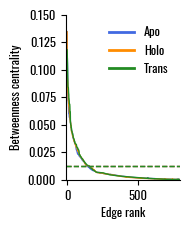

In [5]:
from kneed import KneeLocator
b_apo = pd.read_csv('../04-dynet/7XP4/Betweennesses.dat',sep='\t')
b_holo = pd.read_csv('../04-dynet/7XP6/Betweennesses.dat',sep='\t')
b_trans = pd.read_csv('../04-dynet/noLig/Betweennesses.dat',sep='\t')

b_apo = b_apo.sort_values(by=['btw'],ascending=False)
b_holo = b_holo.sort_values(by=['btw'],ascending=False)
b_trans = b_trans.sort_values(by=['btw'],ascending=False)

# plot
fig, ax = plt.subplots(figsize=(5/2.54,6/2.54))
ax.plot(b_apo.btw,label='Apo',color=palette[0])
ax.plot(b_holo.btw,label='Holo',color=palette[1])
ax.plot(b_trans.btw,label='Trans',color=palette[2])
ax.set_xlabel('Edge rank')
ax.set_ylabel('Betweenness centrality')
ax.set_xlim(-10,800)
ax.set_ylim(0,0.15)
for i,dd in enumerate([b_apo,b_holo,b_trans]):
    vv = dd.sort_values(by=['btw'],ascending=False).btw.values
    kn = KneeLocator(np.arange(len(vv)), vv, curve='convex', direction='decreasing', interp_method='polynomial')

    # vdiff = np.diff(vv)
    # vv = vv[:-1][vdiff<-1e-4]
    # vdiff =vdiff[vdiff<-1e-4]
    # mm = np.argmax(vdiff)
    print(f'Threshold: {vv[kn.knee]}')
    ax.axhline(y=vv[kn.knee],color=palette[i],ls='--')
g = ax.legend()
for line in g.get_lines():
    line.set_linewidth(2)
sns.despine()
fig.tight_layout()
fig.savefig('../05-Images/Betweennesses_Rank.png',dpi=600,facecolor='w')

In [11]:
maxall = np.max(np.concatenate((b_apo.btw,b_holo.btw,b_trans.btw)))
print(f"Overall maximum betweenness: {maxall:.4f}")
print(f"Apo: {np.max(b_apo.btw):.4f}")
print(f"Holo: {np.max(b_holo.btw):.4f}")
print(f"Trans: {np.max(b_trans.btw):.4f}")
print(f"Threshold: {0.0120984938609683/maxall:.4f}")

Overall maximum betweenness: 0.1347
Apo: 0.1347
Holo: 0.1345
Trans: 0.1183
Threshold: 0.0898


Create files with normalized betweenness for plotting

In [62]:
# recreate the Betweenness file with the normalized values
for winIndx in range(dnad_apo.numWinds): 
    normCorMat = copy.deepcopy( dnad_apo.corrMatAll[winIndx,:,:] )
    normCorMat /= normCorMat.max()
    fileName = "../04-dynet/7XP4/NORMALL_networkData_Betweenness_window_{}.dat".format(winIndx)
    with open(fileName, "w") as outfile:
        
        for pair,btw in dnad_apo.btws[winIndx].items():
            
            node1 = pair[0]
            node2 = pair[1]

            # If either node does not belong to any community (assigned to community -1), also skip the edge.
            if (nodeCommNP[node1, winIndx] < 0) or (nodeCommNP[node2, winIndx] < 0):
                continue
            
            community1 = int(nodeCommNP[node1, winIndx])
            community2 = int(nodeCommNP[node2, winIndx])
            
            # Get VMD indices for the atoms
            # VMD uses a 0-based index, so we subtract 1 from the PDB index
            pdbIndx1 = dnad_apo.nodesAtmSel.atoms[node1].id -1
            pdbIndx2 = dnad_apo.nodesAtmSel.atoms[node2].id -1

            string = "{} {} {} {} {} {}".format(pdbIndx1, pdbIndx2, 
                                                normCorMat[ node1, node2], btw/maxall, 
                                                community1, community2)
            
            outfile.write( string + "\n" )

for winIndx in range(dnad_holo.numWinds): 
    normCorMat = copy.deepcopy( dnad_holo.corrMatAll[winIndx,:,:] )
    normCorMat /= normCorMat.max()
    fileName = "../04-dynet/7XP6/NORMALL_networkData_Betweenness_window_{}.dat".format(winIndx)
    with open(fileName, "w") as outfile:
        
        for pair,btw in dnad_holo.btws[winIndx].items():
            
            node1 = pair[0]
            node2 = pair[1]

            # If either node does not belong to any community (assigned to community -1), also skip the edge.
            if (nodeCommNP[node1, winIndx] < 0) or (nodeCommNP[node2, winIndx] < 0):
                continue
            
            community1 = int(nodeCommNP[node1, winIndx])
            community2 = int(nodeCommNP[node2, winIndx])
            
            # Get VMD indices for the atoms
            # VMD uses a 0-based index, so we subtract 1 from the PDB index
            pdbIndx1 = dnad_holo.nodesAtmSel.atoms[node1].id -1
            pdbIndx2 = dnad_holo.nodesAtmSel.atoms[node2].id -1

            string = "{} {} {} {} {} {}".format(pdbIndx1, pdbIndx2, 
                                                normCorMat[ node1, node2], btw/maxall, 
                                                community1, community2)
            
            outfile.write( string + "\n" )

for winIndx in range(dnad_trans.numWinds): 
    normCorMat = copy.deepcopy( dnad_trans.corrMatAll[winIndx,:,:] )
    normCorMat /= normCorMat.max()
    fileName = "../04-dynet/noLig/NORMALL_networkData_Betweenness_window_{}.dat".format(winIndx)
    with open(fileName, "w") as outfile:
        
        for pair,btw in dnad_trans.btws[winIndx].items():
            
            node1 = pair[0]
            node2 = pair[1]

            # If either node does not belong to any community (assigned to community -1), also skip the edge.
            if (nodeCommNP[node1, winIndx] < 0) or (nodeCommNP[node2, winIndx] < 0):
                continue
            
            community1 = int(nodeCommNP[node1, winIndx])
            community2 = int(nodeCommNP[node2, winIndx])
            
            # Get VMD indices for the atoms
            # VMD uses a 0-based index, so we subtract 1 from the PDB index
            pdbIndx1 = dnad_trans.nodesAtmSel.atoms[node1].id -1
            pdbIndx2 = dnad_trans.nodesAtmSel.atoms[node2].id -1

            string = "{} {} {} {} {} {}".format(pdbIndx1, pdbIndx2, 
                                                normCorMat[ node1, node2], btw/maxall, 
                                                community1, community2)
            
            outfile.write( string + "\n" )


Consider the values of betweennesses of edges between helices

In [12]:
df_apo = pd.read_csv('../04-dynet/7XP4/Betweennesses.dat', sep='\t')
df_holo = pd.read_csv('../04-dynet/7XP6/Betweennesses.dat', sep='\t')
df_trans = pd.read_csv('../04-dynet/noLig/Betweennesses.dat', sep='\t')

# merge the dataframes so that we have all possible edges with the betweeness values of the three systems
df = pd.merge(df_apo, df_holo, how='outer', on=['segName1', 'resname1', 'resIndx1', 'segName2', 'resname2', 'resIndx2'])
df = pd.merge(df, df_trans, how='outer', on=['segName1', 'resname1', 'resIndx1', 'segName2', 'resname2', 'resIndx2'])

# change the segname to label the helices
lim_tm1 = [3,39]
lim_ic1 = [40,41]
lim_tm2 = [42,72]
lim_ec1 = [73,76]
lim_tm3 = [77,111]
lim_ic2 = [112,123]
lim_tm4 = [124,154]
lim_ec2 = [155,172]
lim_tm5 = [173,213]
lim_ic3 = [214,217]
lim_tm6 = [218,254]
lim_ec3 = [255,257]
lim_tm7 = [258,282]
lim_h8  = [283,301]

for i,row in df.iterrows():
    if row['resIndx1'] in range(lim_tm1[0],lim_tm1[1]+1):
        df.loc[i,'segName1'] = 'TM1'
    elif row['resIndx1'] in range(lim_ic1[0],lim_ic1[1]+1):
        df.loc[i,'segName1'] = 'ICL1'
    elif row['resIndx1'] in range(lim_tm2[0],lim_tm2[1]+1): 
        df.loc[i,'segName1'] = 'TM2'
    elif row['resIndx1'] in range(lim_ec1[0],lim_ec1[1]+1):
        df.loc[i,'segName1'] = 'ECL1'
    elif row['resIndx1'] in range(lim_tm3[0],lim_tm3[1]+1):
        df.loc[i,'segName1'] = 'TM3'
    elif row['resIndx1'] in range(lim_ic2[0],lim_ic2[1]+1):
        df.loc[i,'segName1'] = 'ICL2'
    elif row['resIndx1'] in range(lim_tm4[0],lim_tm4[1]+1):
        df.loc[i,'segName1'] = 'TM4'
    elif row['resIndx1'] in range(lim_ec2[0],lim_ec2[1]+1):
        df.loc[i,'segName1'] = 'ECL2'
    elif row['resIndx1'] in range(lim_tm5[0],lim_tm5[1]+1):
        df.loc[i,'segName1'] = 'TM5'
    elif row['resIndx1'] in range(lim_ic3[0],lim_ic3[1]+1):
        df.loc[i,'segName1'] = 'ICL3'
    elif row['resIndx1'] in range(lim_tm6[0],lim_tm6[1]+1):
        df.loc[i,'segName1'] = 'TM6'
    elif row['resIndx1'] in range(lim_ec3[0],lim_ec3[1]+1):
        df.loc[i,'segName1'] = 'ECL3'
    elif row['resIndx1'] in range(lim_tm7[0],lim_tm7[1]+1):
        df.loc[i,'segName1'] = 'TM7'
    elif row['resIndx1'] in range(lim_h8[0],lim_h8[1]+1):
        df.loc[i,'segName1'] = 'H8'
    else:
        row['segName1'] = 'LIG'

    if row['resIndx2'] in range(lim_tm1[0],lim_tm1[1]+1):
        df.loc[i,'segName2'] = 'TM1'
    elif row['resIndx2'] in range(lim_ic1[0],lim_ic1[1]+1):
        df.loc[i,'segName2'] = 'ICL1'
    elif row['resIndx2'] in range(lim_tm2[0],lim_tm2[1]+1): 
        df.loc[i,'segName2'] = 'TM2'
    elif row['resIndx2'] in range(lim_ec1[0],lim_ec1[1]+1):
        df.loc[i,'segName2'] = 'ECL1'
    elif row['resIndx2'] in range(lim_tm3[0],lim_tm3[1]+1):
        df.loc[i,'segName2'] = 'TM3'
    elif row['resIndx2'] in range(lim_ic2[0],lim_ic2[1]+1):
        df.loc[i,'segName2'] = 'ICL2'
    elif row['resIndx2'] in range(lim_tm4[0],lim_tm4[1]+1):
        df.loc[i,'segName2'] = 'TM4'
    elif row['resIndx2'] in range(lim_ec2[0],lim_ec2[1]+1):
        df.loc[i,'segName2'] = 'ECL2'
    elif row['resIndx2'] in range(lim_tm5[0],lim_tm5[1]+1):
        df.loc[i,'segName2'] = 'TM5'
    elif row['resIndx2'] in range(lim_ic3[0],lim_ic3[1]+1):
        df.loc[i,'segName2'] = 'ICL3'
    elif row['resIndx2'] in range(lim_tm6[0],lim_tm6[1]+1):
        df.loc[i,'segName2'] = 'TM6'
    elif row['resIndx2'] in range(lim_ec3[0],lim_ec3[1]+1):
        df.loc[i,'segName2'] = 'ECL3'
    elif row['resIndx2'] in range(lim_tm7[0],lim_tm7[1]+1):
        df.loc[i,'segName2'] = 'TM7'
    elif row['resIndx2'] in range(lim_h8[0],lim_h8[1]+1):
        df.loc[i,'segName2'] = 'H8'
    else:
        df.loc[i,'segName2'] = 'LIG'
        
# put 0 to the NaN values
df = df.fillna(0)

# rename the columns
df.columns = ['segName1', 'resname1', 'resIndx1', 'segName2', 'resname2', 'resIndx2', 'btw_apo', 'btw_holo', 'btw_trans']

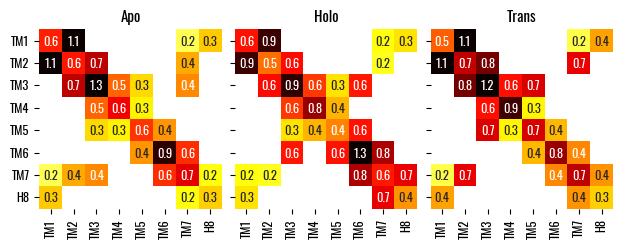

In [14]:
segs = ['TM1', 'TM2', 'TM3', 'TM4', 'TM5', 'TM6', 'TM7', 'H8']
# segs = ['TM1', 'ICL1', 'TM2', 'ECL1', 'TM3', 'ICL2', 'TM4', 'ECL2', 'TM5','ICL3', 'TM6', 'ECL3', 'TM7', 'H8']
mat_btw_apo = np.zeros((len(segs),len(segs)))
mat_btw_holo = np.zeros((len(segs),len(segs)))
mat_btw_trans = np.zeros((len(segs),len(segs)))

for i,lim1 in enumerate(segs):
    for j,lim2 in enumerate(segs):
        if i<=j:
            mat_btw_apo[i,j] = df.loc[((df.segName1 == lim1) & (df.segName2 == lim2)) | \
                                              ((df.segName2 == lim1) & (df.segName1 == lim2))].loc[df.btw_apo>0.012098].btw_apo.max()*10
            mat_btw_holo[i,j] = df.loc[((df.segName1 == lim1) & (df.segName2 == lim2)) | \
                                              ((df.segName2 == lim1) & (df.segName1 == lim2))].loc[df.btw_holo>0.012098].btw_holo.max()*10
            mat_btw_trans[i,j] = df.loc[((df.segName1 == lim1) & (df.segName2 == lim2)) | \
                                              ((df.segName2 == lim1) & (df.segName1 == lim2))].loc[df.btw_trans>0.012098].btw_trans.max()*10
        else:
            mat_btw_apo[i,j] = mat_btw_apo[j,i]
            mat_btw_holo[i,j] = mat_btw_holo[j,i]
            mat_btw_trans[i,j] = mat_btw_trans[j,i]

# plot the matrices
fig, ax = plt.subplots(1,3, figsize=(16/2.54,6.5/2.54))
sns.heatmap(mat_btw_apo, cmap='hot_r', ax=ax[0], vmin=0, vmax=1, annot=True,cbar=False,fmt='.1f')
sns.heatmap(mat_btw_holo, cmap='hot_r', ax=ax[1], vmin=0, vmax=1, annot=True,cbar=False,fmt='.1f')
sns.heatmap(mat_btw_trans, cmap='hot_r', ax=ax[2], vmin=0, vmax=1, annot=True,cbar=False,fmt='.1f')
ax[0].set_title('Apo')
ax[1].set_title('Holo')
ax[2].set_title('Trans')
for a in ax:
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_xticks(np.arange(len(segs))+0.5)
    a.set_yticks(np.arange(len(segs))+0.5)
    a.set_xticklabels(segs,rotation=90)
ax[0].set_yticklabels(segs,rotation=0)
ax[1].tick_params(labelleft=False)
ax[2].tick_params(labelleft=False)
fig.tight_layout()
fig.savefig('../05-Images/max_btwness_helices.png',dpi=600,bbox_inches='tight',facecolor='white')


Node betweenness centrality, splitting residues by helices

In [15]:
# define path for data files - bound
dataDir = "../04-dynet/7XP6/"
fileNameRoot = "dnaData"
fullPathRoot = os.path.join(dataDir, fileNameRoot)
dcdVizFile = fullPathRoot + "_reducedTraj.dcd"
pdbVizFile = fullPathRoot + "_reducedTraj.pdb"
workUviz = mda.Universe(pdbVizFile, dcdVizFile)
workDir = os.path.abspath('./difference_corr/')
# Load the Dynamic Network Analyzer object - bound
dnad_holo = dna.datastorage.DNAdata()
dnad_holo.loadFromFile(fullPathRoot)
dnad_holo.nodesAtmSel = workUviz.atoms[ dnad_holo.nodesIxArray ]

# define path for data files - unbound
dataDir = "../04-dynet/7XP4/"
fileNameRoot = "dnaData"
fullPathRoot = os.path.join(dataDir, fileNameRoot)
dcdVizFile = fullPathRoot + "_reducedTraj.dcd"
pdbVizFile = fullPathRoot + "_reducedTraj.pdb"
workUviz = mda.Universe(pdbVizFile, dcdVizFile)
# Load the Dynamic Network Analyzer object - unbound
dnad_apo = dna.datastorage.DNAdata()
dnad_apo.loadFromFile(fullPathRoot)
dnad_apo.nodesAtmSel = workUviz.atoms[ dnad_apo.nodesIxArray ]

# define path for data files - noLig
dataDir = "../04-dynet/noLig/"
fileNameRoot = "dnaData"
fullPathRoot = os.path.join(dataDir, fileNameRoot)
dcdVizFile = fullPathRoot + "_reducedTraj.dcd"
pdbVizFile = fullPathRoot + "_reducedTraj.pdb"
workUviz = mda.Universe(pdbVizFile, dcdVizFile)
# Load the Dynamic Network Analyzer object - noLig
dnad_trans = dna.datastorage.DNAdata()
dnad_trans.loadFromFile(fullPathRoot)
dnad_trans.nodesAtmSel = workUviz.atoms[ dnad_trans.nodesIxArray ]

atomToNode int64 (2466,) 2466
contactMat int64 (300, 300) 90000
corrMatAll float64 (1, 300, 300) 90000
distsAll float64 (1, 300, 300) 90000
maxDirectDist float64 () 1
maxDist float64 () 1
nodesIxArray int64 (300,) 300
numNodes int32 () 1
atomToNode int64 (2441,) 2441
contactMat int64 (299, 299) 89401
corrMatAll float64 (1, 299, 299) 89401
distsAll float64 (1, 299, 299) 89401
maxDirectDist float64 () 1
maxDist float64 () 1
nodesIxArray int64 (299,) 299
numNodes int32 () 1
atomToNode int64 (2441,) 2441
contactMat int64 (299, 299) 89401
corrMatAll float64 (1, 299, 299) 89401
distsAll float64 (1, 299, 299) 89401
maxDirectDist float64 () 1
maxDist float64 () 1
nodesIxArray int64 (299,) 299
numNodes int32 () 1


/home/marco/anaconda3/envs/dynet/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [16]:
nodeBtw_apo, nodeBtw_holo, nodeBtw_trans = [], [], []
for winIndx in range(dnad_apo.numWinds):
    nodeBtw_apo.append( nx.betweenness_centrality(dnad_apo.nxGraphs[winIndx],weight='dist') )

for winIndx in range(dnad_holo.numWinds):
    nodeBtw_holo.append( nx.betweenness_centrality(dnad_holo.nxGraphs[winIndx],weight='dist') )

for winIndx in range(dnad_trans.numWinds):
    nodeBtw_trans.append( nx.betweenness_centrality(dnad_trans.nxGraphs[winIndx],weight='dist') )

In [17]:
# write in a file the edges with the highest betweeness value - unbound
with open('../04-dynet/7XP4/Betweennesses_nodes.dat','w') as f:
    f.write("segName\tresname\tresIndx\thelix\tbtw\n")
    for node, btw in nodeBtw_apo[0].items():
        resname = dnad_apo.nodesAtmSel.atoms[node].resname
        resIndx = dnad_apo.nodesAtmSel.atoms[node].resid
        segName = dnad_apo.nodesAtmSel.atoms[node].segid
        if resIndx < 40:
            helix = "TM1"
        elif resIndx < 42:
            helix = "ICL1"
        elif resIndx < 72:
            helix = "TM2"
        elif resIndx < 77:
            helix = "ECL1"
        elif resIndx < 111:
            helix = "TM3"
        elif resIndx < 124:
            helix = "ICL2"
        elif resIndx < 154:
            helix = "TM4"
        elif resIndx < 173:
            helix = "ECL2"
        elif resIndx < 213:
            helix = "TM5"
        elif resIndx < 218:
            helix = "ICL3"
        elif resIndx < 254:
            helix = "TM6"
        elif resIndx < 258:
            helix = "ECL3"
        elif resIndx < 282:
            helix = "TM7"
        elif resIndx <= 301:
            helix = "H8"
        else:
            helix = "LIG"
        f.write("{}\t{}\t{}\t{}\t{}\n".format(segName, resname, resIndx, helix, btw))

# write in a file the edges with the highest betweeness value - bound
with open('../04-dynet/7XP6/Betweennesses_nodes.dat','w') as f:
    f.write("segName\tresname\tresIndx\thelix\tbtw\n")
    for node, btw in nodeBtw_holo[0].items():
        resname = dnad_holo.nodesAtmSel.atoms[node].resname
        resIndx = dnad_holo.nodesAtmSel.atoms[node].resid
        segName = dnad_holo.nodesAtmSel.atoms[node].segid
        if resIndx < 40:
            helix = "TM1"
        elif resIndx < 42:
            helix = "ICL1"
        elif resIndx < 72:
            helix = "TM2"
        elif resIndx < 77:
            helix = "ECL1"
        elif resIndx < 111:
            helix = "TM3"
        elif resIndx < 124:
            helix = "ICL2"
        elif resIndx < 154:
            helix = "TM4"
        elif resIndx < 173:
            helix = "ECL2"
        elif resIndx < 213:
            helix = "TM5"
        elif resIndx < 218:
            helix = "ICL3"
        elif resIndx < 254:
            helix = "TM6"
        elif resIndx < 258:
            helix = "ECL3"
        elif resIndx < 282:
            helix = "TM7"
        elif resIndx <= 301:
            helix = "H8"
        else:
            helix = "LIG"
        f.write("{}\t{}\t{}\t{}\t{}\n".format(segName, resname, resIndx, helix, btw))

# write in a file the edges with the highest betweeness value - noLig
with open('../04-dynet/noLig/Betweennesses_nodes.dat','w') as f:
    f.write("segName\tresname\tresIndx\thelix\tbtw\n")
    for node, btw in nodeBtw_trans[0].items():
        resname = dnad_trans.nodesAtmSel.atoms[node].resname
        resIndx = dnad_trans.nodesAtmSel.atoms[node].resid
        segName = dnad_trans.nodesAtmSel.atoms[node].segid
        if resIndx < 40:
            helix = "TM1"
        elif resIndx < 42:
            helix = "ICL1"
        elif resIndx < 72:
            helix = "TM2"
        elif resIndx < 77:
            helix = "ECL1"
        elif resIndx < 111:
            helix = "TM3"
        elif resIndx < 124:
            helix = "ICL2"
        elif resIndx < 154:
            helix = "TM4"
        elif resIndx < 173:
            helix = "ECL2"
        elif resIndx < 213:
            helix = "TM5"
        elif resIndx < 218:
            helix = "ICL3"
        elif resIndx < 254:
            helix = "TM6"
        elif resIndx < 258:
            helix = "ECL3"
        elif resIndx < 282:
            helix = "TM7"
        elif resIndx <= 301:
            helix = "H8"
        else:
            helix = "LIG"
        f.write("{}\t{}\t{}\t{}\t{}\n".format(segName, resname, resIndx, helix, btw))

Threshold: 0.0459855828983345
Threshold: 0.0291351484815155
Threshold: 0.0381217092626488


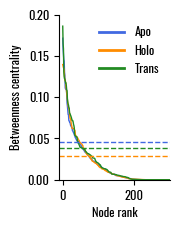

In [29]:
from kneed import KneeLocator
b_apo = pd.read_csv('../04-dynet/7XP4/Betweennesses_nodes.dat',sep='\t')
b_holo = pd.read_csv('../04-dynet/7XP6/Betweennesses_nodes.dat',sep='\t')
b_trans = pd.read_csv('../04-dynet/noLig/Betweennesses_nodes.dat',sep='\t')

b_apo = b_apo.sort_values(by=['btw'],ascending=False)
b_holo = b_holo.sort_values(by=['btw'],ascending=False)
b_trans = b_trans.sort_values(by=['btw'],ascending=False)

# plot
fig, ax = plt.subplots(figsize=(5/2.54,6/2.54))
ax.plot(b_apo.btw.values,label='Apo',color=palette[0])
ax.plot(b_holo.btw.values,label='Holo',color=palette[1])
ax.plot(b_trans.btw.values,label='Trans',color=palette[2])
ax.set_xlabel('Node rank')
ax.set_ylabel('Betweenness centrality')
ax.set_xlim(-10,300)
ax.set_ylim(0,0.2)
for i,dd in enumerate([b_apo,b_holo,b_trans]):
    vv = dd.sort_values(by=['btw'],ascending=False).btw.values
    kn = KneeLocator(np.arange(len(vv)), vv, curve='convex', direction='decreasing', interp_method='polynomial')
    print(f'Threshold: {vv[kn.knee]}')
    ax.axhline(y=vv[kn.knee],color=palette[i],ls='--')
g = ax.legend()
for line in g.get_lines():
    line.set_linewidth(2)
sns.despine()
fig.tight_layout()
fig.savefig('../05-Images/Betweennesses_Nodes_Rank.png',dpi=600,facecolor='w')

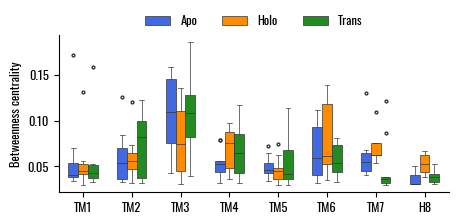

In [40]:
btws_apo = pd.read_csv('../04-dynet/7XP4/Betweennesses_nodes.dat', sep='\t')
btws_apo['system'] = 'Apo'
btws_holo = pd.read_csv('../04-dynet/7XP6/Betweennesses_nodes.dat', sep='\t')
btws_holo['system'] = 'Holo'
btws_trans = pd.read_csv('../04-dynet/noLig/Betweennesses_nodes.dat', sep='\t')
btws_trans['system'] = 'Trans'
btws = pd.concat([btws_apo, btws_holo, btws_trans])
helices = ['TM1', 'TM2', 'TM3', 'TM4', 'TM5', 'TM6', 'TM7', 'H8']
# boxplots
fig, ax = plt.subplots(figsize=(12/2.54, 6/2.54))
# plot the edges with the same color as the face
# knee nodes 0.0291351484815155
# knee edges 0.0120984938609683
sns.boxplot(x='helix', y='btw', hue='system', palette=palette[:3], data=btws.loc[(btws.helix.isin(helices)) & (btws.btw>0.0291351484815155)],
            ax=ax, dodge=True, saturation=1, flierprops=dict(marker='o', markersize=2), linewidth=0.5, width=0.6)
ax.set_xlabel('')
ax.set_ylabel('Betweenness centrality')
ax.get_legend().set_title('')
# set legend in three columns
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:3], labels[0:3], loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
sns.despine()
fig.tight_layout()
fig.savefig('../05-Images/Betweennesses_Nodes_boxplot.png', dpi=600, facecolor='white', bbox_inches='tight')

Node eigenvector centrality

In [35]:
# define path for data files - bound
dataDir = "../04-dynet/7XP6/"
fileNameRoot = "dnaData"
fullPathRoot = os.path.join(dataDir, fileNameRoot)
dcdVizFile = fullPathRoot + "_reducedTraj.dcd"
pdbVizFile = fullPathRoot + "_reducedTraj.pdb"
workUviz = mda.Universe(pdbVizFile, dcdVizFile)
workDir = os.path.abspath('./difference_corr/')
# Load the Dynamic Network Analyzer object - bound
dnad_holo = dna.datastorage.DNAdata()
dnad_holo.loadFromFile(fullPathRoot)
dnad_holo.nodesAtmSel = workUviz.atoms[ dnad_holo.nodesIxArray ]

# define path for data files - unbound
dataDir = "../04-dynet/7XP4/"
fileNameRoot = "dnaData"
fullPathRoot = os.path.join(dataDir, fileNameRoot)
dcdVizFile = fullPathRoot + "_reducedTraj.dcd"
pdbVizFile = fullPathRoot + "_reducedTraj.pdb"
workUviz = mda.Universe(pdbVizFile, dcdVizFile)
# Load the Dynamic Network Analyzer object - unbound
dnad_apo = dna.datastorage.DNAdata()
dnad_apo.loadFromFile(fullPathRoot)
dnad_apo.nodesAtmSel = workUviz.atoms[ dnad_apo.nodesIxArray ]

# define path for data files - noLig
dataDir = "../04-dynet/noLig/"
fileNameRoot = "dnaData"
fullPathRoot = os.path.join(dataDir, fileNameRoot)
dcdVizFile = fullPathRoot + "_reducedTraj.dcd"
pdbVizFile = fullPathRoot + "_reducedTraj.pdb"
workUviz = mda.Universe(pdbVizFile, dcdVizFile)
# Load the Dynamic Network Analyzer object - noLig
dnad_trans = dna.datastorage.DNAdata()
dnad_trans.loadFromFile(fullPathRoot)
dnad_trans.nodesAtmSel = workUviz.atoms[ dnad_trans.nodesIxArray ]

atomToNode int64 (2466,) 2466
contactMat int64 (300, 300) 90000
corrMatAll float64 (1, 300, 300) 90000
distsAll float64 (1, 300, 300) 90000
maxDirectDist float64 () 1
maxDist float64 () 1
nodesIxArray int64 (300,) 300
numNodes int32 () 1
atomToNode int64 (2441,) 2441
contactMat int64 (299, 299) 89401
corrMatAll float64 (1, 299, 299) 89401
distsAll float64 (1, 299, 299) 89401
maxDirectDist float64 () 1
maxDist float64 () 1
nodesIxArray int64 (299,) 299
numNodes int32 () 1
atomToNode int64 (2441,) 2441
contactMat int64 (299, 299) 89401
corrMatAll float64 (1, 299, 299) 89401
distsAll float64 (1, 299, 299) 89401
maxDirectDist float64 () 1
maxDist float64 () 1
nodesIxArray int64 (299,) 299
numNodes int32 () 1


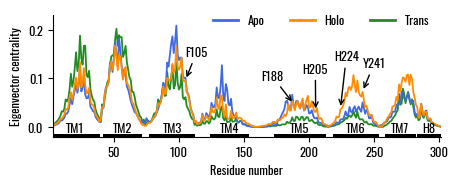

In [43]:
for winIndx in range(dnad_apo.numWinds):
    for pair in dnad_apo.nxGraphs[winIndx].edges.keys():
        dnad_apo.nxGraphs[winIndx].edges[(pair[0], pair[1])]["corr"] = \
            dnad_apo.corrMatAll[winIndx][pair[0], pair[1]]
        
for winIndx in range(dnad_holo.numWinds):
    for pair in dnad_holo.nxGraphs[winIndx].edges.keys():
        dnad_holo.nxGraphs[winIndx].edges[(pair[0], pair[1])]["corr"] = \
            dnad_holo.corrMatAll[winIndx][pair[0], pair[1]]

for winIndx in range(dnad_trans.numWinds):
    for pair in dnad_trans.nxGraphs[winIndx].edges.keys():
        dnad_trans.nxGraphs[winIndx].edges[(pair[0], pair[1])]["corr"] = \
            dnad_trans.corrMatAll[winIndx][pair[0], pair[1]]
        


nodeBtw_apo, nodeBtw_holo, nodeBtw_trans = [], [], []
for winIndx in range(dnad_apo.numWinds):
    nodeBtw_apo.append( nx.eigenvector_centrality(dnad_apo.nxGraphs[winIndx],max_iter=1000,weight='corr') )

for winIndx in range(dnad_holo.numWinds):
    nodeBtw_holo.append( nx.eigenvector_centrality(dnad_holo.nxGraphs[winIndx],max_iter=1000,weight='corr') )

for winIndx in range(dnad_trans.numWinds):
    nodeBtw_trans.append( nx.eigenvector_centrality(dnad_trans.nxGraphs[winIndx],max_iter=1000,weight='corr') )

resids = dnad_apo.nodesAtmSel.resids
fig, ax = plt.subplots(1,1, figsize=(12/2.54,5/2.54))
botlim, w = -0.02,0.005
ax.plot(resids,nodeBtw_apo[0].values(),label="Apo",lw=1.3,color=palette[0],zorder=0)
ax.plot(resids,list(nodeBtw_holo[0].values())[:-1],label="Holo",lw=1.3,color=palette[1],zorder=1)
ax.plot(resids,list(nodeBtw_trans[0].values()),label="Trans",lw=1.3,color=palette[2],zorder=-1)
leg = ax.legend(bbox_to_anchor=(1, 1.1), loc='upper right', ncol=3, frameon=False)
# make thicker legend lines
for line in leg.get_lines():
    line.set_linewidth(2.0)
ax.set_xlim(resids[0],resids[-1])
ax.set_ylim(botlim,0.23)

ax.add_patch(Rectangle((3,botlim),36,w,  fill=True,lw=0,color='k'))
ax.add_patch(Rectangle((42,botlim),30,w, fill=True,lw=0,color='k'))
ax.add_patch(Rectangle((77,botlim),35,w, fill=True,lw=0,color='k'))
ax.add_patch(Rectangle((124,botlim),30,w,fill=True,lw=0,color='k'))
ax.add_patch(Rectangle((173,botlim),40,w,fill=True,lw=0,color='k'))
ax.add_patch(Rectangle((218,botlim),36,w,fill=True,lw=0,color='k'))
ax.add_patch(Rectangle((258,botlim),24,w,fill=True,lw=0,color='k'))
ax.add_patch(Rectangle((283,botlim),18,w,fill=True,lw=0,color='k'))
ax.text(20, botlim+w+0.005,"TM1",fontsize=9, ha='center')
ax.text(57, botlim+w+0.005,"TM2",fontsize=9, ha='center')
ax.text(95, botlim+w+0.005,"TM3",fontsize=9, ha='center')
ax.text(139,botlim+w+0.005,"TM4",fontsize=9, ha='center')
ax.text(193,botlim+w+0.005,"TM5",fontsize=9, ha='center')
ax.text(236,botlim+w+0.005,"TM6",fontsize=9, ha='center')
ax.text(270,botlim+w+0.005,"TM7",fontsize=9, ha='center')
ax.text(292,botlim+w+0.005,"H8", fontsize=9, ha='center')

# create a vertical arrow that points to res 105
ax.annotate('F105', xy=(105, nodeBtw_holo[0][105-3]+0.001), xycoords='data',
            xytext=(105, nodeBtw_holo[0][105-3]+0.05), textcoords='data',
            arrowprops=dict(arrowstyle='->',lw=1, color='k'))
# create a vertical arrow that points to res 205
ax.annotate('H205', xy=(205, nodeBtw_holo[0][205-3]+0.001), xycoords='data',
            xytext=(205-10, nodeBtw_holo[0][205-3]+0.08), textcoords='data',
            arrowprops=dict(arrowstyle='->',lw=1, color='k'))
# create a vertical arrow that points to res 241
ax.annotate('Y241', xy=(241, nodeBtw_holo[0][241-3]+0.001), xycoords='data',
            xytext=(241, nodeBtw_holo[0][241-3]+0.05), textcoords='data',
            arrowprops=dict(arrowstyle='->',lw=1, color='k'))
# create a vertical arrow that points to res 188
ax.annotate('F188', xy=(188, nodeBtw_holo[0][188-3]+0.001), xycoords='data',
            xytext=(188-25, nodeBtw_holo[0][188-3]+0.05), textcoords='data',
            arrowprops=dict(arrowstyle='->',lw=1, color='k'))
# create a vertical arrow that points to res 224
ax.annotate('H224', xy=(224, nodeBtw_holo[0][224-3]+0.001), xycoords='data',
            xytext=(224-5, nodeBtw_holo[0][224-3]+0.1), textcoords='data',
            arrowprops=dict(arrowstyle='->',lw=1, color='k'))




ax.set_xlabel("Residue number")
ax.set_ylabel("Eigenvector centrality")

sns.despine()
fig.tight_layout()
fig.savefig("../05-Images/Eigenvector_centrality.png", dpi=600,facecolor='w')

# 8. Analysis of correlation of transmembrane helices using the generalized correlation matrix 

In [113]:
def _prepare_phi_psi(n_frames, kNeighb=6):
    """
    Pre-calculate Psi values to be used in the calculation of Mutual Information.
    """
    psi = np.zeros(n_frames + 1)
    psi[1] = -0.57721566490153
    for ii in range(n_frames):
        if ii > 0:
            psi[ii + 1] = psi[ii] + 1/ii
    phi = np.ndarray(kNeighb + 1)
    for ii in range(1, (kNeighb + 1)):
            phi[ii] = psi[ii] - 1 / ii
    return phi, psi

def _prepare_traj(u, sel, n_res, n_dims=3, start=0, stop=-1, step=1):
    """
    Standardize variables in trajectory data.
    This function stores the trajectory data in a new format to accelerate the
    estimation of mutual information coefficients. The estimation of mutual
    information coefficients assumes that the input trajectory of random variables
    (in this case, positions of atoms) is provided in a variable-dimension-step
    format (or "atom by x/y/z by frame" for molecular dynamics data). However,
    the standard MDAnalysis trajectory format if "frame by atom by x/y/z".
    """
    # compute number of frames, taking into account the start, stop and step
    if stop == -1:
        n_frames = len(u.trajectory[start::step])
    else:
        n_frames = len(u.trajectory[start:stop:step])
    traj = np.zeros([n_res, n_dims, n_frames])

    # Copy trajectory
    if stop == -1:
        for jj, ts in enumerate(u.trajectory[start::step]):
            for rr in range(n_res):
                for dim in range(n_dims):
                    traj[rr, dim, jj] = u.select_atoms(sel).positions[rr, dim]
    else:
        for jj, _ in enumerate(u.trajectory[start:stop:step]):
            for rr in range(n_res):
                for dim in range(n_dims):
                    traj[rr, dim, jj] = u.select_atoms(sel).positions[rr, dim]

    # standardize trajectory
    for rr in range(n_res):
        for dim in range(n_dims):
            # Normalize each dimension.
            traj[rr,dim,:] = (traj[rr,dim,:] - traj[rr,dim,:].mean()) / traj[rr,dim,:].std()

            # Offset all data by minimum normalized value.
            traj[rr, dim, :] -= traj[rr, dim, :].min()
    
    return traj

def _compute_MI_2(trj, n_frames, n_dims, k_neighb, phi, psi): 
    """
    Calculate mutual information coefficients.

    This function estimates the mutual information coefficient based on
    `Kraskov et. al. (2004) <https://doi.org/10.1103/PhysRevE.69.066138>`_,
    using the rectangle method.
    This calculation assumes that the input trajectory of two random variables
    (in this case, positions of two atoms) is provided in a
    variable-dimension-step format (or "atom by x/y/z by frame" for molecular
    dynamics data). It also assumes that all trajectory data has been
    standardized.
    """

    dxy = 0.0

    diffX = np.zeros(n_frames)
    diffY = np.zeros(n_frames)
    tmpDiff = np.zeros(n_frames)
    sortIndx = np.zeros(n_frames)

    for step in range(n_frames):
        diffX.fill(0)
        diffY.fill(0)
        tmpDiff.fill(0)
        sortIndx.fill(0)

        for d in range(n_dims):
            # The trajectory contains only the positions of the two atoms
            tmpDiff = np.abs(trj[0, d, :] - trj[0, d, step])
            diffX = np.where(diffX > tmpDiff, diffX, tmpDiff)

            tmpDiff = np.abs(trj[1, d, :] - trj[1, d, step])
            diffY = np.where(diffY > tmpDiff, diffY, tmpDiff)

        # Create an array with indices of sorted distance arrays
        sortIndx = np.argsort(np.where(diffX > diffY, diffX, diffY))
        epsx = 0
        epsy = 0

        # Get the maximum distance in each dimension, for each variable,
        #  among k nearest neighbors.
        # Add one to the count to include the k-th neighbour, as the first index
        #  in the list it the frame itself.
        for kindx in range(1, k_neighb + 1):

            for d in range(n_dims):
                # For variable "i"
                dist = np.abs(trj[0, d, step] - trj[0, d, sortIndx[kindx]])
                if epsx < dist:
                    epsx = dist

                # For variable "j"
                dist = np.abs(trj[1, d, step] - trj[1, d, sortIndx[kindx]])
                if epsy < dist:
                    epsy = dist

        # Count the number of frames in which the point is within "eps-" distance from
        #   the position in frame "step". Subtract one so not to count the frame itself.
        nx = len(np.nonzero(diffX <= epsx)[0]) - 1
        ny = len(np.nonzero(diffY <= epsy)[0]) - 1

        dxy += psi[nx] + psi[ny]

    dxy /= n_frames

    # Mutual Information R
    return phi[k_neighb] + psi[n_frames] - dxy

def _MI_to_r(mi, n_dims=3):
    """
    Transforms Mutual Information into Generalized Correlation Coefficient
    """

    # Assures that the Mutual Information estimate is not lower than zero.
    corr = max(0.0, mi)

    # Determine generalized correlation coefficient from the Mutual Information
    corr = np.sqrt(1 - np.exp(-corr * (2.0 / n_dims)))

    return corr

def calcCor(u, sel='all',k_neighb=6, start=0, stop=-1, step=1):
    """Main interface for correlation calculation."""

    # For 3D atom position data
    n_dims = 3
    if stop == -1:
        n_frames = len(u.trajectory[start::step])
    else:
        n_frames = len(u.trajectory[start:stop:step])
    n_res = u.select_atoms(sel).n_residues
    phi, psi = _prepare_phi_psi(n_frames, k_neighb)

    # Prepares trajectory (format and standardization)
    traj = _prepare_traj(u, sel, n_res, n_dims, start, stop, step)

    # create a list of pairs of residues, from 0 to n_res
    pair_array = np.array(np.triu_indices(n_res, 1)).T
    corrMat = np.zeros([n_res, n_res])
    for atmList in tqdm(pair_array):
        mi = _compute_MI_2(traj[atmList, :, :], n_frames, n_dims, k_neighb, phi, psi)

        corr = _MI_to_r(mi, n_dims)

        corrMat[atmList[0], atmList[1]] = corr
        corrMat[atmList[1], atmList[0]] = corr

    # Checks that the correlation matrix is symmetric
    if not np.allclose(corrMat[:, :], corrMat[:, :].T, atol=0.1):
        err_str = f"ERROR: Correlation matrix is NOT symmetric!!"
        raise Exception(err_str)
    return corrMat

def add_helices(ax,botlim=0,w=0.02,fz=9,tm=True,loops=True,invert=False,space=0.8):
    from matplotlib.patches import Rectangle
    if not invert:
        ax.add_patch(Rectangle((3-3,botlim),36,w,  fill=True,lw=0,color='k',zorder=0))
        ax.add_patch(Rectangle((3-3,botlim),299,w, fill=True,lw=0,color='darkgrey',zorder=-1))
        ax.add_patch(Rectangle((42-3,botlim),30,w, fill=True,lw=0,color='k',zorder=0))
        ax.add_patch(Rectangle((77-3,botlim),35,w, fill=True,lw=0,color='k',zorder=0))
        ax.add_patch(Rectangle((124-3,botlim),30,w,fill=True,lw=0,color='k',zorder=0))
        ax.add_patch(Rectangle((173-3,botlim),40,w,fill=True,lw=0,color='k',zorder=0))
        ax.add_patch(Rectangle((218-3,botlim),36,w,fill=True,lw=0,color='k',zorder=0))
        ax.add_patch(Rectangle((258-3,botlim),24,w,fill=True,lw=0,color='k',zorder=0))
        ax.add_patch(Rectangle((283-3,botlim),18,w,fill=True,lw=0,color='k',zorder=0))
        if tm:
            ax.text(20-3, botlim+w+space,"TM1",fontsize=fz, ha='center')
            ax.text(57-3, botlim+w+space,"TM2",fontsize=fz, ha='center')
            ax.text(95-3, botlim+w+space,"TM3",fontsize=fz, ha='center')
            ax.text(139-3,botlim+w+space,"TM4",fontsize=fz, ha='center')
            ax.text(193-3,botlim+w+space,"TM5",fontsize=fz, ha='center')
            ax.text(236-3,botlim+w+space,"TM6",fontsize=fz, ha='center')
            ax.text(270-3,botlim+w+space,"TM7",fontsize=fz, ha='center')
            ax.text(292-3,botlim+w+space,"H8", fontsize=fz, ha='center')
        if loops:
            ax.text((3+36+42)/2,botlim+w+space,"ICL1",fontsize=fz, ha='center',color='darkgrey')
            ax.text((42+30+77)/2, botlim+w+space,"ECL1",fontsize=fz, ha='center',color='darkgrey')
            ax.text((77+35+124)/2,botlim+w+space,"ICL2",fontsize=fz, ha='center',color='darkgrey')
            ax.text((124+30+173)/2,botlim+w+space,"ECL2",fontsize=fz, ha='center',color='darkgrey')
            ax.text((173+40+218)/2,botlim+w+space,"ICL3",fontsize=fz, ha='center',color='darkgrey')
            ax.text((218+36+258)/2,botlim+w+space,"ECL3",fontsize=fz, ha='center',color='darkgrey')
    else:
        ax.add_patch(Rectangle((botlim,3-3),w,36,  fill=True,lw=0,color='k',zorder=0))
        ax.add_patch(Rectangle((botlim,3-3),w,299, fill=True,lw=0,color='darkgrey',zorder=-1))
        ax.add_patch(Rectangle((botlim,42-3),w,30, fill=True,lw=0,color='k',zorder=0))
        ax.add_patch(Rectangle((botlim,77-3),w,35, fill=True,lw=0,color='k',zorder=0))
        ax.add_patch(Rectangle((botlim,124-3),w,30,fill=True,lw=0,color='k',zorder=0))
        ax.add_patch(Rectangle((botlim,173-3),w,40,fill=True,lw=0,color='k',zorder=0))
        ax.add_patch(Rectangle((botlim,218-3),w,36,fill=True,lw=0,color='k',zorder=0))
        ax.add_patch(Rectangle((botlim,258-3),w,24,fill=True,lw=0,color='k',zorder=0))
        ax.add_patch(Rectangle((botlim,283-3),w,18,fill=True,lw=0,color='k',zorder=0))
        if tm:
            ax.text(botlim+space,20-3,"TM1",fontsize=fz, ha='center',va='center',rotation=-90)
            ax.text(botlim+space,57-3,"TM2",fontsize=fz, ha='center',va='center',rotation=-90)
            ax.text(botlim+space,95-3,"TM3",fontsize=fz, ha='center',va='center',rotation=-90)
            ax.text(botlim+space,139-3,"TM4",fontsize=fz, ha='center',va='center',rotation=-90)
            ax.text(botlim+space,193-3,"TM5",fontsize=fz, ha='center',va='center',rotation=-90)
            ax.text(botlim+space,236-3,"TM6",fontsize=fz, ha='center',va='center',rotation=-90)
            ax.text(botlim+space,270-3,"TM7",fontsize=fz, ha='center',va='center',rotation=-90)
            ax.text(botlim+space,292-3,"H8", fontsize=fz, ha='center',va='center',rotation=-90)
        if loops:
            ax.text(botlim+w+space,(3+36+42)/2,"ICL1",fontsize=fz, ha='center',va='center',color='darkgrey',rotation=-90)
            ax.text(botlim+w+space,(42+30+77)/2, "ECL1",fontsize=fz, ha='center',va='center',color='darkgrey',rotation=-90)
            ax.text(botlim+w+space,(77+35+124)/2,"ICL2",fontsize=fz, ha='center',va='center',color='darkgrey',rotation=-90)
            ax.text(botlim+w+space,(124+30+173)/2,"ECL2",fontsize=fz, ha='center',va='center',color='darkgrey',rotation=-90)
            ax.text(botlim+w+space,(173+40+218)/2,"ICL3",fontsize=fz, ha='center',va='center',color='darkgrey',rotation=-90)
            ax.text(botlim+w+space,(218+36+258)/2,"ECL3",fontsize=fz, ha='center',va='center',color='darkgrey',rotation=-90)
    

In [ ]:
from tqdm.notebook import tqdm
u = mda.Universe('../04-dynet/7XP4/system.pdb','../01-sim/7XP4/cat_1ns.xtc')
corrMat_unbound = calcCor(u,sel='segid A and name CA',k_neighb=7)

u = mda.Universe('../04-dynet/7XP6/system.pdb','../01-sim/7XP6/cat_1ns.xtc')
corrMat_bound = calcCor(u,sel='segid A and name CA',k_neighb=7)

u = mda.Universe('../04-dynet/noLig/system.pdb','../01-sim/7XP6_noLig/cat_1ns.xtc')
corrMat_noLig = calcCor(u,sel='segid A and name CA',k_neighb=7)

# save the correlation matrices
np.savetxt('../04-dynet/7XP4/corrMat_unbound.csv',corrMat_unbound,fmt='%.4f',delimiter=',')
np.savetxt('../04-dynet/7XP6/corrMat_bound.csv',corrMat_bound,fmt='%.4f',delimiter=',')
np.savetxt('../04-dynet/noLig/corrMat_noLig.csv',corrMat_noLig,fmt='%.4f',delimiter=',')

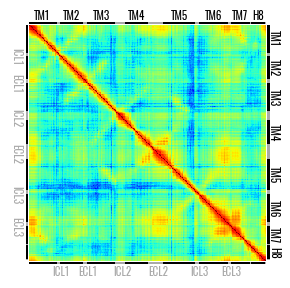

In [138]:
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

# load the correlation matrices
corrMat = np.loadtxt('../04-dynet/noLig/corrMat_noLig.csv',delimiter=',')
outfile = '../05-Images/corrMat_Trans.png'
np.fill_diagonal(corrMat,1)

# plot the correlation matrix, adding rectangles on top and right to highlight the TM helices
#make outer gridspec
fig = plt.figure(figsize=(8/2.54,8/2.54))
gs1 = gridspec.GridSpec(3, 3, wspace = .01, hspace = .01, height_ratios=[0.01,1,0.01], width_ratios=[0.01,1,0.01],figure=fig)


# plot the correlation matrix in the lower left panel
ax_heat = plt.subplot(gs1[1,1])
ax_heat.set_aspect('equal')
sns.heatmap(corrMat,cmap='jet',vmin=0,vmax=1,ax=ax_heat,cbar=False)
ax_heat.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

# plot rectangles on top axis to highlight the TM helices
ax_top = plt.subplot(gs1[0,1])
ax_top.axis('off')
ax_top.set_ylim(0,1)
ax_top.set_xlim(0,300)
add_helices(ax_top,botlim=0,w=1,fz=8,loops=False)

ax_bottom = plt.subplot(gs1[2,1])
ax_bottom.axis('off')
ax_bottom.set_ylim(0,1)
ax_bottom.set_xlim(0,300)
add_helices(ax_bottom,botlim=0,w=1,fz=8,tm=False,space=-6)

ax_right = plt.subplot(gs1[1,2])
ax_right.axis('off')
ax_right.set_xlim(0,1)
ax_right.set_ylim(0,300)
ax_right.invert_yaxis()
add_helices(ax_right,botlim=0,w=1,fz=8,loops=False,invert=True,space=3)

ax_left = plt.subplot(gs1[1,0])
ax_left.axis('off')
ax_left.set_xlim(0,1)
ax_left.set_ylim(0,300)
ax_left.invert_yaxis()
add_helices(ax_left,botlim=0,w=1,fz=8,tm=False,invert=True,space=-5)

fig.savefig(outfile,dpi=600,facecolor='w',bbox_inches='tight')

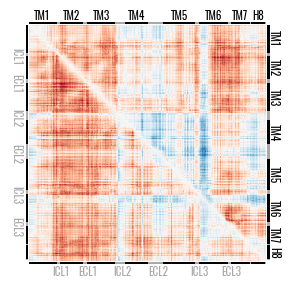

In [140]:
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

# load the correlation matrices
corrMat_apo = np.loadtxt('../04-dynet/7XP4/corrMat_unbound.csv',delimiter=',')
corrMat_holo = np.loadtxt('../04-dynet/7XP6/corrMat_bound.csv',delimiter=',')
corrMat_trans = np.loadtxt('../04-dynet/noLig/corrMat_noLig.csv',delimiter=',')

corrDiff = np.zeros((299,299))
corrDiff[np.triu_indices(299,1)] = corrMat_apo[np.triu_indices(299,1)] - corrMat_holo[np.triu_indices(299,1)]
corrDiff[np.tril_indices(299,-1)] = corrMat_trans[np.tril_indices(299,-1)] - corrMat_holo[np.tril_indices(299,-1)]
outfile = '../05-Images/corrMat_Diff.png'
# plot the correlation matrix, adding rectangles on top and right to highlight the TM helices
#make outer gridspec
fig = plt.figure(figsize=(8/2.54,8/2.54))
gs1 = gridspec.GridSpec(3, 3, wspace = .01, hspace = .01, height_ratios=[0.01,1,0.01], width_ratios=[0.01,1,0.01],figure=fig)


# plot the correlation matrix in the lower left panel
ax_heat = plt.subplot(gs1[1,1])
ax_heat.set_aspect('equal')
sns.heatmap(corrDiff,cmap='RdBu',vmin=-0.5,vmax=0.5,ax=ax_heat,cbar=False)
ax_heat.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

# plot rectangles on top axis to highlight the TM helices
ax_top = plt.subplot(gs1[0,1])
ax_top.axis('off')
ax_top.set_ylim(0,1)
ax_top.set_xlim(0,300)
add_helices(ax_top,botlim=0,w=1,fz=8,loops=False)

ax_bottom = plt.subplot(gs1[2,1])
ax_bottom.axis('off')
ax_bottom.set_ylim(0,1)
ax_bottom.set_xlim(0,300)
add_helices(ax_bottom,botlim=0,w=1,fz=8,tm=False,space=-6)

ax_right = plt.subplot(gs1[1,2])
ax_right.axis('off')
ax_right.set_xlim(0,1)
ax_right.set_ylim(0,300)
ax_right.invert_yaxis()
add_helices(ax_right,botlim=0,w=1,fz=8,loops=False,invert=True,space=3)

ax_left = plt.subplot(gs1[1,0])
ax_left.axis('off')
ax_left.set_xlim(0,1)
ax_left.set_ylim(0,300)
ax_left.invert_yaxis()
add_helices(ax_left,botlim=0,w=1,fz=8,tm=False,invert=True,space=-5)

fig.savefig(outfile,dpi=600,facecolor='w',bbox_inches='tight')

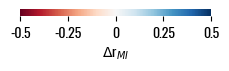

In [174]:
# create a horizontal colorbar, cmap jet, labels from 0 to 1
fig, ax = plt.subplots(1,1,figsize=(6/2.54,2/2.54))
cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=-0.5, vmax=0.5)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label(r'$\Delta$r$_{MI}$',fontsize=10)
cb1.set_ticks([-0.5,-0.25,0,0.25,0.5])
cb1.set_ticklabels(['-0.5','-0.25','0','0.25','0.5'])
cb1.ax.tick_params(labelsize=10)
cb1.outline.set_visible(False)
fig.tight_layout()
fig.savefig('../05-Images/colorbar_RdBu.png',dpi=600,facecolor='w')

Plot as B-factor

In [45]:
resint = 188
corrMat_unbound = np.loadtxt('../04-dynet/7XP4/corrMat_unbound.csv',delimiter=',')
corrMat_bound = np.loadtxt('../04-dynet/7XP6/corrMat_bound.csv',delimiter=',')
corrMat_noLig = np.loadtxt('../04-dynet/noLig/corrMat_noLig.csv',delimiter=',')
# set diagonal to one
np.fill_diagonal(corrMat_unbound,1)
np.fill_diagonal(corrMat_bound,1)
np.fill_diagonal(corrMat_noLig,1)
# load a pdb file of the receptor in bound state
u = mda.Universe('../04-dynet/7XP6/system.pdb')

# add correlation as b factors to the pdb file
u.add_TopologyAttr('tempfactors')
bf = corrMat_bound[resint-3,:]
bf = np.append(bf,0)
for i,r in enumerate(u.residues):
    for a in r.atoms:
        a.tempfactor = bf[i]
# write the pdb file
with mda.Writer(f'../04-dynet/correlations/corr{resint:.0f}_bound.pdb') as W:
    W.write(u)

u = mda.Universe('../04-dynet/7XP4/system.pdb')
# add correlation as b factors to the pdb file
u.add_TopologyAttr('tempfactors')
bf = corrMat_unbound[resint-3,:]
bf = np.append(bf,0)
for i,r in enumerate(u.residues):
    for a in r.atoms:
        a.tempfactor = bf[i]
# write the pdb file
with mda.Writer(f'../04-dynet/correlations/corr{resint:.0f}_unbound.pdb') as W:
    W.write(u)

# noLig
u = mda.Universe('../04-dynet/noLig/system.pdb')
# add correlation as b factors to the pdb file
u.add_TopologyAttr('tempfactors')
bf = corrMat_noLig[resint-3,:]
bf = np.append(bf,0)
for i,r in enumerate(u.residues):
    for a in r.atoms:
        a.tempfactor = bf[i]
# write the pdb file
with mda.Writer(f'../04-dynet/correlations/corr{resint:.0f}_noLig.pdb') as W:
    W.write(u)



# add the differnce on unbound state
u = mda.Universe('../04-dynet/7XP6/system.pdb')
bf = corrMat_unbound[resint-3,:]-corrMat_bound[resint-3,:]
bf = np.append(bf,0)
for i,r in enumerate(u.residues):
    for a in r.atoms:
        a.tempfactor = bf[i]
# write the pdb file
with mda.Writer(f'../04-dynet/correlations/corr{resint:.0f}_diff.pdb') as W:
    W.write(u)